Import Required Libraries

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, Pool

from sklearn.metrics import confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

Load and Preprocess Data

In [40]:
# Load dataset (adjust path as needed)
df = pd.read_csv('UCI_Credit_Card.csv')

# Basic inspection
print(df.shape)
df.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Handle Missing & Encode Categorical

In [41]:
# Drop columns with more than 40% missing
df = df.loc[:, df.isnull().mean() < 0.4]

# Fill numeric NaNs with median
for col in df.select_dtypes(include=np.number).columns:
    df[col] = df[col].fillna(df[col].median())

# Encode categoricals
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col].astype(str))

Define Target and Features

In [45]:
X = df.drop('default.payment.next.month', axis=1)
y = df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

**Train Models**

Logistic Regression

In [46]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
probs_lr = lr.predict_proba(X_test)[:,1]

CatBoost

In [47]:
cat = CatBoostClassifier(verbose=0, random_state=42)
cat.fit(X_train, y_train)
probs_cat = cat.predict_proba(X_test)[:,1]

Business Cost Evaluation

In [48]:
def evaluate_cost(y_true, y_proba, threshold, cost_fp=10000, cost_fn=1000):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    return total_cost, fp, fn

# Example at threshold = 0.5
cost, fp, fn = evaluate_cost(y_test, probs_cat, threshold=0.5)
print(f"Cost at 0.5 threshold: {cost} (FP={fp}, FN={fn})")

Cost at 0.5 threshold: 3547000 (FP=270, FN=847)


Optimize Threshold

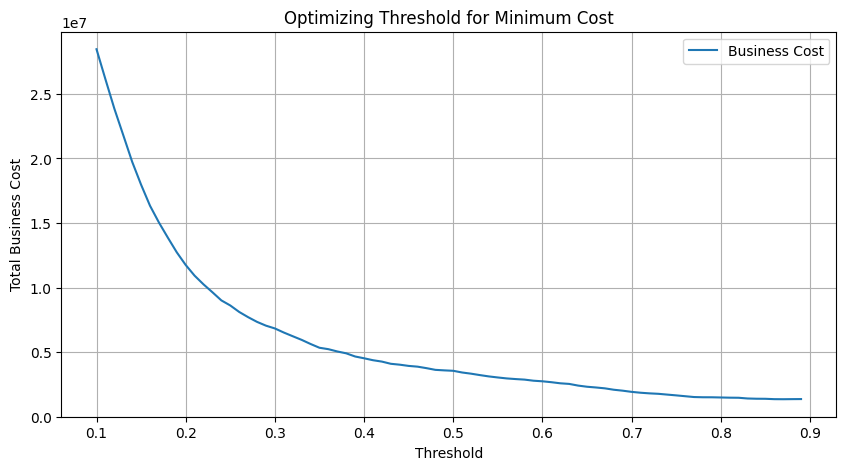

Best Threshold: 0.87 with Min Cost: 1345000


In [49]:
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for t in thresholds:
    c, _, _ = evaluate_cost(y_test, probs_cat, threshold=t)
    costs.append(c)

# Plot
plt.figure(figsize=(10,5))
plt.plot(thresholds, costs, label='Business Cost')
plt.xlabel('Threshold')
plt.ylabel('Total Business Cost')
plt.title('Optimizing Threshold for Minimum Cost')
plt.grid(True)
plt.legend()
plt.show()

# Best threshold
best_threshold = thresholds[np.argmin(costs)]
print(f"Best Threshold: {best_threshold:.2f} with Min Cost: {min(costs)}")

Feature Importance (CatBoost)

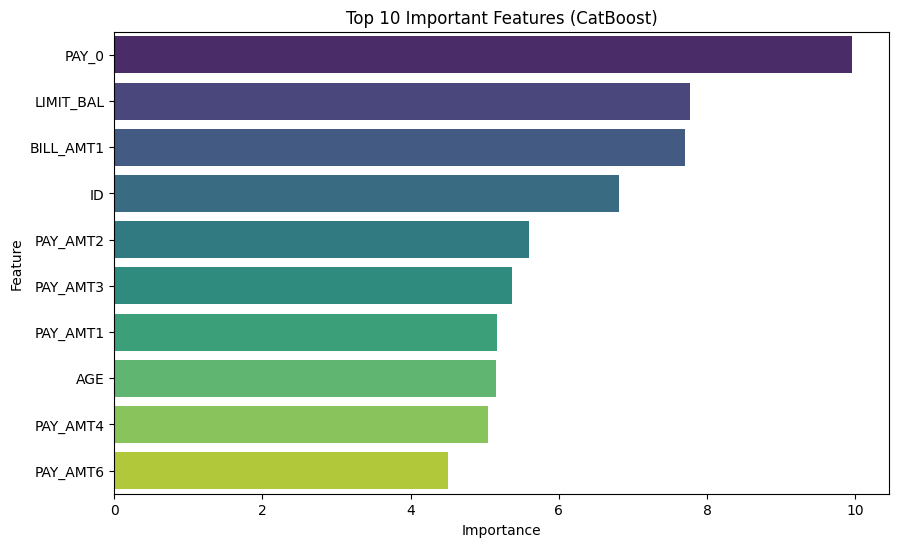

In [50]:
importances = cat.get_feature_importance(Pool(X_train, y_train))
feat_names = X.columns

feat_imp = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_imp = feat_imp.sort_values('Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
plt.title("Top 10 Important Features (CatBoost)")
plt.show()